In [8]:
field_cate_indices_path = './data/ipinyou/field_cates_index_not_aligned.csv'
fields_index = {}
fields_index_inverse = {}
f = open(field_cate_indices_path, 'r')

for line in f.readlines():
    field_name, indices = line.strip().split('\t')
    indices = np.array([int(i) for i in indices.split(',')])
    fields_index[field_name] = indices
    for ind in indices:
        fields_index_inverse[ind] = field_name

In [10]:
from cat2vec import Options, Cat2Vec
import tensorflow as tf
from sample_encoding import *
from utility import load_data
import random
import numpy as np
import pandas as pd
from time import time

def get_substitute_cate(sample, target_index, opts):
    field_i = fields_index_inverse.get(sample[target_index])
    if field_i is None:
        field_i = np.random.choice(fields_index.keys(),1)[0]
    field_cates = fields_index[field_i]
    rst = np.random.choice(field_cates,1)[0]
#     print('preivous',(target_index,sample[target_index],fields_index_inverse[sample[target_index]]))
#     print('substitue',(rst,fields_index_inverse[rst]))
    if len(field_cates) == 1:
        rst = np.random.randint(opts.vocabulary_size)
    return rst

def generate_fake_sample(data, opts, substitute_num=3, field_weight={}):
    while True:
        temp = data[np.random.randint(len(data))]
        temp_sequence_length = len(temp)
        temp = temp[0:opts.sequence_length]
#         print(temp)
        if len(temp) < opts.sequence_length:
            gap = opts.sequence_length - len(temp)
            temp = np.array(temp + [0] * gap)
        else:
            temp_sequence_length = opts.sequence_length
        assert len(temp) == opts.sequence_length
        targets_to_avoid = set(temp)
        indices_to_avoid = set()
        substitute_index = np.random.randint(temp_sequence_length)
        substitute_target = get_substitute_cate(temp, substitute_index, opts)
        for _ in range(substitute_num):
            while substitute_index in indices_to_avoid:
                substitute_index = np.random.randint(temp_sequence_length)
            indices_to_avoid.add(substitute_index)
            
            count = 0
            while substitute_target in targets_to_avoid:
                if count > 5:
                    break
                substitute_target = get_substitute_cate(temp, substitute_index, opts)
                count += 1
            targets_to_avoid.add(substitute_target)
            temp[substitute_index] = substitute_target
        yield temp


def generate_discriminant_batch(data, opts, rate=0.5):
    data_index = 0
    fake_sample_generator = generate_fake_sample(data, opts)
    while True:
        batch = np.ndarray(shape=(opts.batch_size, opts.sequence_length))
        labels = np.ndarray(shape=(opts.batch_size, opts.num_classes))
        for i in xrange(opts.batch_size):
            target = np.zeros(opts.num_classes)
            if random.random() > rate:
                target[1] = 1.
                temp = data[data_index][-opts.sequence_length-1:-1]
                if len(temp) < opts.sequence_length:
                    gap = opts.sequence_length - len(temp)
                    temp = np.array(temp + [0] * gap)
                assert len(temp) == opts.sequence_length
                batch[i] = temp
                labels[i] = target
                data_index = (data_index + 1) % len(data)
            else:
                target[0] = 1.
                batch[i] = fake_sample_generator.next()
                # batch[i] = np.random.choice(opts.vocabulary_size, opts.sequence_length)
                labels[i] = target

        yield batch, labels


class DiscriminantCat2Vec(Cat2Vec):

    def __init__(self, options, session, cate2id, id2cate, pre_trained_emb=None, trainable=True, pre_trained_path=None):
        self.pre_trained_emb = None
        self.trainable = trainable
        if pre_trained_path is not None:
            self.load_pre_trained(pre_trained_path)
        Cat2Vec.__init__(self, options, session, cate2id, id2cate)
        # self.build_graph()

    def load_pre_trained(self, path):
        self.pre_trained_emb = np.array(pd.read_csv(path, sep=',',header=None),dtype=np.float32)
        print('pre-trained shape',self.pre_trained_emb.shape)

    def build_graph(self):
        """Build the model graph."""
        opts = self._options
        first_indices, second_indices = \
            get_batch_pair_indices(opts.batch_size, opts.sequence_length)
        # print(first_indices.shape)
        # the following is just for example, base class should not include this
        # with self._graph.as_default():
        self.train_inputs = tf.placeholder(tf.int32,
                                           shape=[opts.batch_size,
                                                  opts.sequence_length])
        self.train_labels = tf.placeholder(tf.int32, shape=[opts.batch_size,
                                                            opts.num_classes])
        l2_loss = tf.constant(0.0)
        with tf.device('/cpu:0'):

            if self.pre_trained_emb is None:
                self.embeddings = tf.Variable(tf.random_normal([opts.vocabulary_size,
                                  opts.embedding_size],
                                 stddev=1.0 / np.sqrt(opts.embedding_size)
                                 ))
            else:
                if self.pre_trained_emb.shape == (opts.vocabulary_size, opts.embedding_size):
                    self.embeddings = tf.get_variable(name="embeddings",
                                                      shape=[opts.vocabulary_size, opts.embedding_size],
                                                      dtype=tf.float32,
                                                      initializer=tf.constant_initializer(self.pre_trained_emb),
                                                      trainable=self.trainable)
                    print('Inited by pre-trained embeddings')
                else:
                    print('pre_trained_emb shape', self.pre_trained_emb.shape )
                    print('vocabulary_size,embedding_size',(opts.vocabulary_size, opts.embedding_size))
                    raise Exception('Error', 'pre_trained_emb size mismatch')

            embed = tf.nn.embedding_lookup(self.embeddings, self.train_inputs)
            l2_loss += tf.nn.l2_loss(embed)
            encoded = sample_encoding(embed, opts.interaction_times,
                                      opts.batch_size, opts.sequence_length,
                                      opts.sequence_length, first_indices,
                                      second_indices, opts.gate_type,
                                      opts.norm_type)
            encoded = tf.reshape(embed,[opts.batch_size,-1])
            encoded = tf.concat(1,[encoded,tf.reshape(embed,[opts.batch_size,-1])])
            with tf.name_scope("output"):
                encoded_size = encoded.get_shape().as_list()[1]
                W, b = weight_bias([encoded_size, opts.num_classes], [
                                   opts.num_classes], bias_init=0.)
                l2_loss += tf.nn.l2_loss(W)
                l2_loss += tf.nn.l2_loss(b)
                scores = tf.matmul(encoded, W) + b
                self.predictions = tf.argmax(scores, 1, name="predictions")

            with tf.name_scope("loss"):
                losses = tf.nn.softmax_cross_entropy_with_logits(
                    scores, tf.to_float(self.train_labels))
                self.loss = tf.reduce_mean(losses) + opts.l2_reg_lambda * l2_loss

            with tf.name_scope("accuracy"):
                correct_predictions = tf.equal(
                    self.predictions, tf.argmax(self.train_labels, 1))
                self.accuracy = tf.reduce_mean(
                    tf.cast(correct_predictions, "float"), name="accuracy")

            optimizer = \
                tf.train.GradientDescentOptimizer(opts.learning_rate)
#             self.loss = tf.clip_by_value(self.loss,-10,10)
#             optimizer = tf.train.AdamOptimizer()
            self.train_operator = \
                optimizer.minimize(self.loss,
                                   gate_gradients=optimizer.GATE_NONE)
        tf.initialize_all_variables().run()
        print("Initialized")

    def train(self, batch_generator, num_steps):
        opts = self._options
        average_loss = 0.
        acc = 0.
        start = time()
        for step in xrange(num_steps):
            batch_inputs, batch_labels = batch_generator.next()
            feed_dict = {self.train_inputs: batch_inputs,
                         self.train_labels: batch_labels}
            _, loss, accuracy = self._session.run([self.train_operator,
                                                   self.loss,
                                                   self.accuracy],
                                                  feed_dict=feed_dict)
            average_loss += loss
            acc += accuracy
            if step % 10000 == 0:
                t = time()-start
                if step > 0:
                    average_loss /= 10000
                    t  /= 10000
                    acc /= 10000
                print("Average loss at step ", step, ": ", average_loss,
                    ' accuracy: ', acc, 'time', t)
                average_loss = 0
            if step % 50000 == 0:
                print('Eval at step ', step)
                self.eval_clustering()
        self.eval()


In [ ]:
# print('Loading data...')
# data, id2cate, cate2id, vocabulary_size = load_data(debug=False)

In [11]:
opts = Options()
opts.sequence_length = 24
opts.vocabulary_size = vocabulary_size
opts.norm_type = 'l2'
opts.gate_type = 'mul'
opts.batch_size = 32
opts.embedding_size = 32
opts.interaction_times = 3
opts.learning_rate = 0.1
opts.l2_reg_lambda = 0.1
batch_generator = generate_discriminant_batch(data, opts)

pre_trained_path = './data/ipinyou/pre_trained_embs_72746_skip_cat_32.csv'
pre_trained_path = None
print('Building graph')
with tf.Graph().as_default(), tf.Session() as session:
    discr_cat2vec = DiscriminantCat2Vec(opts, session, id2cate, cate2id,
                                        pre_trained_emb=None,
                                        trainable=True,
                                        pre_trained_path=pre_trained_path)
    print('Training model')
    discr_cat2vec.train(batch_generator, 100001)
    final_embeddings = discr_cat2vec.embeddings.eval()

Building graph
('Eval analogy file: ', './data/ipinyou/questions.txt')
('Questions: ', 351)
('Skipped: ', 0)
Initialized
Training model
('Average loss at step ', 0, ': ', 40.010719299316406, ' accuracy: ', 0.65625, 'time', 0.1658468246459961)
('Eval at step ', 0)
('avg distance for field:', 'city', ':', [0.9952243])
('avg distance for field:', 'domain', ':', [0.99222481])
('avg distance for field:', 'ad_slot_visibility', ':', [0.88747036])
('avg distance for field:', 'user_id', ':', [0.94600046])
('avg distance for field:', 'ad_slot_width', ':', [0.96308047])
('avg distance for field:', 'ad_slot_format', ':', [0.6372624])
('avg distance for field:', 'url', ':', [0.99363208])
('avg distance for field:', 'ip', ':', [0.99192053])
('avg distance for field:', 'creative_id', ':', [0.91755891])
('avg distance for field:', 'hour', ':', [0.95785326])
('avg distance for field:', 'ad_slot_floor_price', ':', [0.99017799])
('avg distance for field:', 'weekday', ':', [0.91316539])
('avg distance for

In [12]:
# final_embeddings = final_embedding
f = open('./data/ipinyou/pre_trained_embs_72746_discri_32_random.csv.csv','w')
for line in final_embeddings:
    f.write(','.join([str(l) for l in line])+'\n')
f.close()
print(np.array(final_embeddings).shape)

(72746, 32)


In [13]:
reverse_dictionary = {}
for i in range(len(id2cate)):
    reverse_dictionary[i] = id2cate[i]
dictionary = cate2id

In [56]:
%matplotlib inline
figure_base_path = './figure/'
import matplotlib.patches as mpatches
def get_colors(cates):
    import six
    from matplotlib import colors
    colors_ = list(six.iteritems(colors.cnames))
    cates_set = list(set(cates))
    colors_mapping = {}
    for i in range(len(cates_set)):
        colors_mapping[cates_set[i]] = colors_[i][0]
    colors_mapping
    cates = [colors_mapping.get(c) for c in cates]
    return cates

def plot_with_labels(low_dim_embs, labels, cates, filename='all_500sample.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(30, 20))  #in inches
    cates_c = get_colors(cates)
    for color, cate in set(zip(cates_c,cates)):
        x, y = low_dim_embs[0,:]
        plt.scatter(x, y, c=color, label=cate, s=200, alpha=0.7, edgecolors='none')
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y, c=cates_c[i], s=300, alpha=0.7, edgecolors='none')
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(0.8, 0.95),
                 textcoords='offset points',
                 ha='right',
                 va='top',
                    size=15)
    plt.legend()
    plt.savefig(figure_base_path + filename,format='pdf', )
    plt.show()


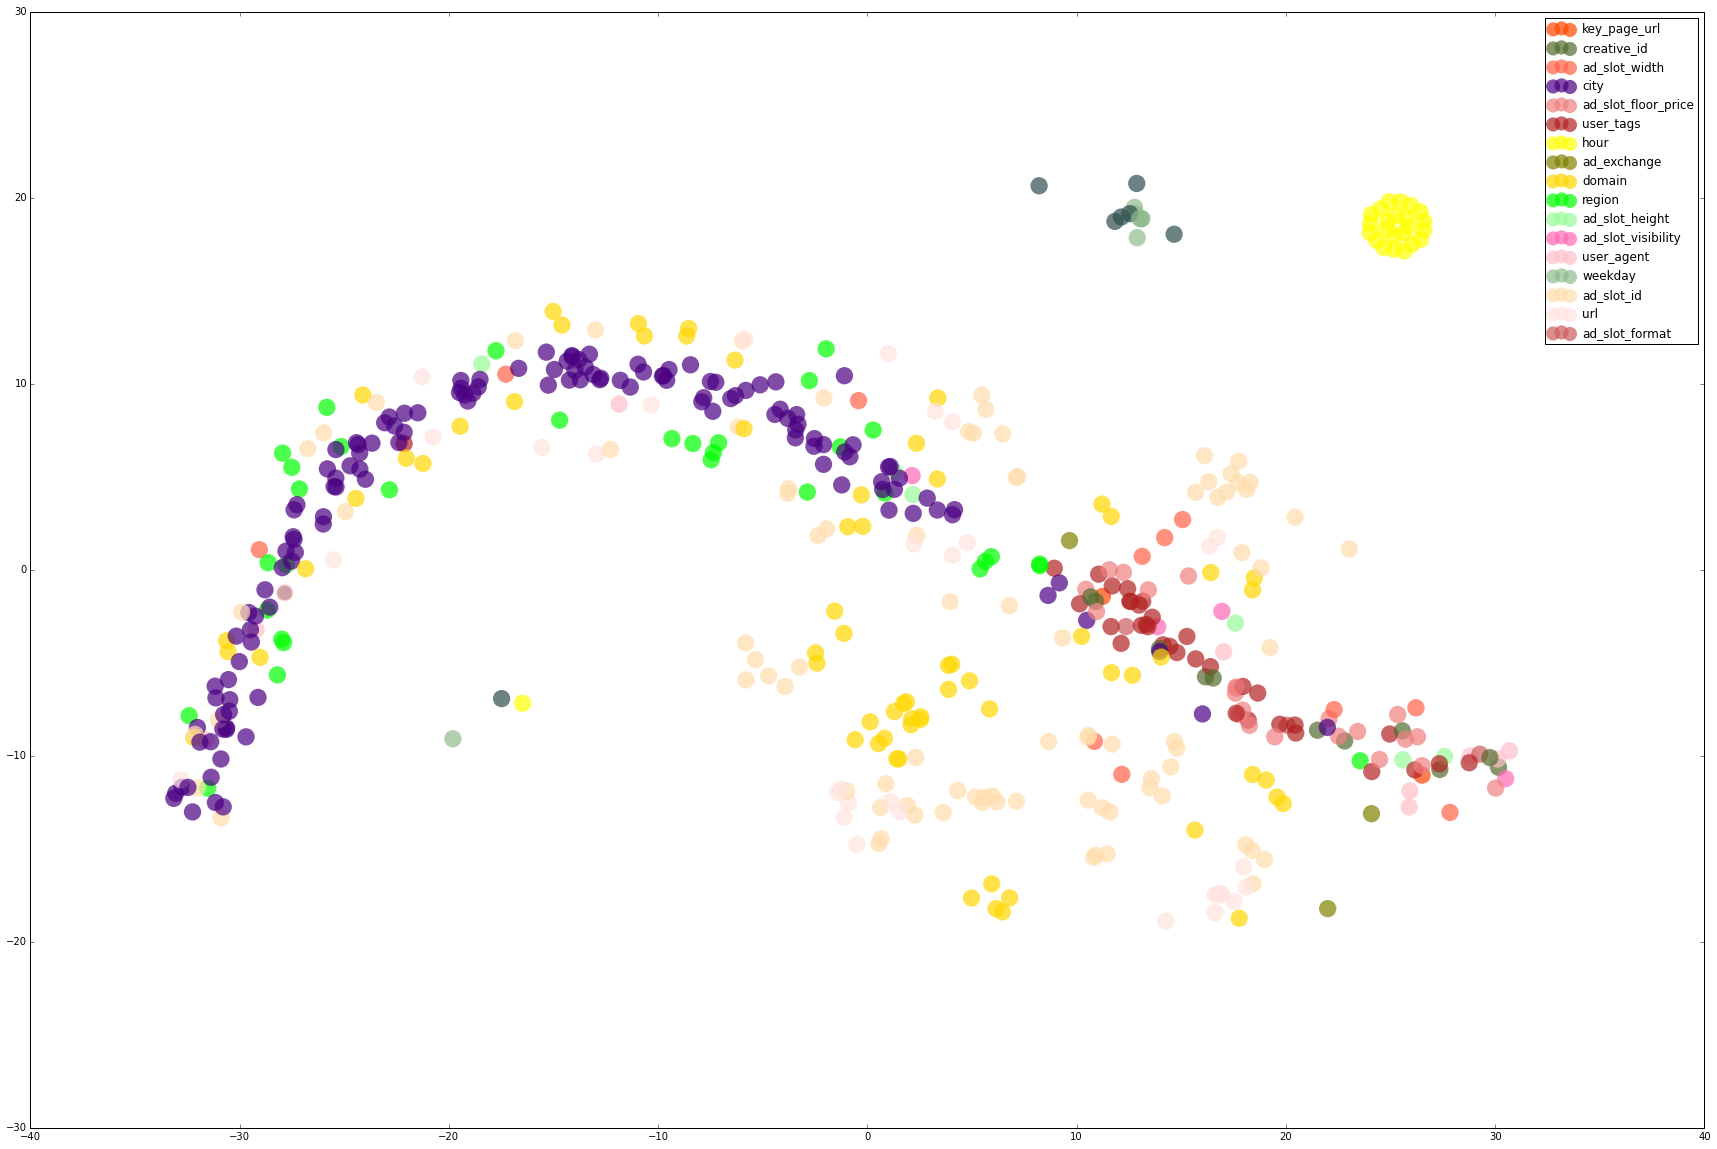

In [57]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
    # reverse_dictionary[i].split('_')[-1][0:10]
    labels = ['' for i in xrange(plot_only)]
    cates = [fields_index_inverse.get(i) for i in xrange(plot_only)]
#     cates = ['_'.join(cat) for cat in cates]
    plot_with_labels(low_dim_embs, labels, cates ,filename='all_500_dirc_32_random_3.pdf')

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")


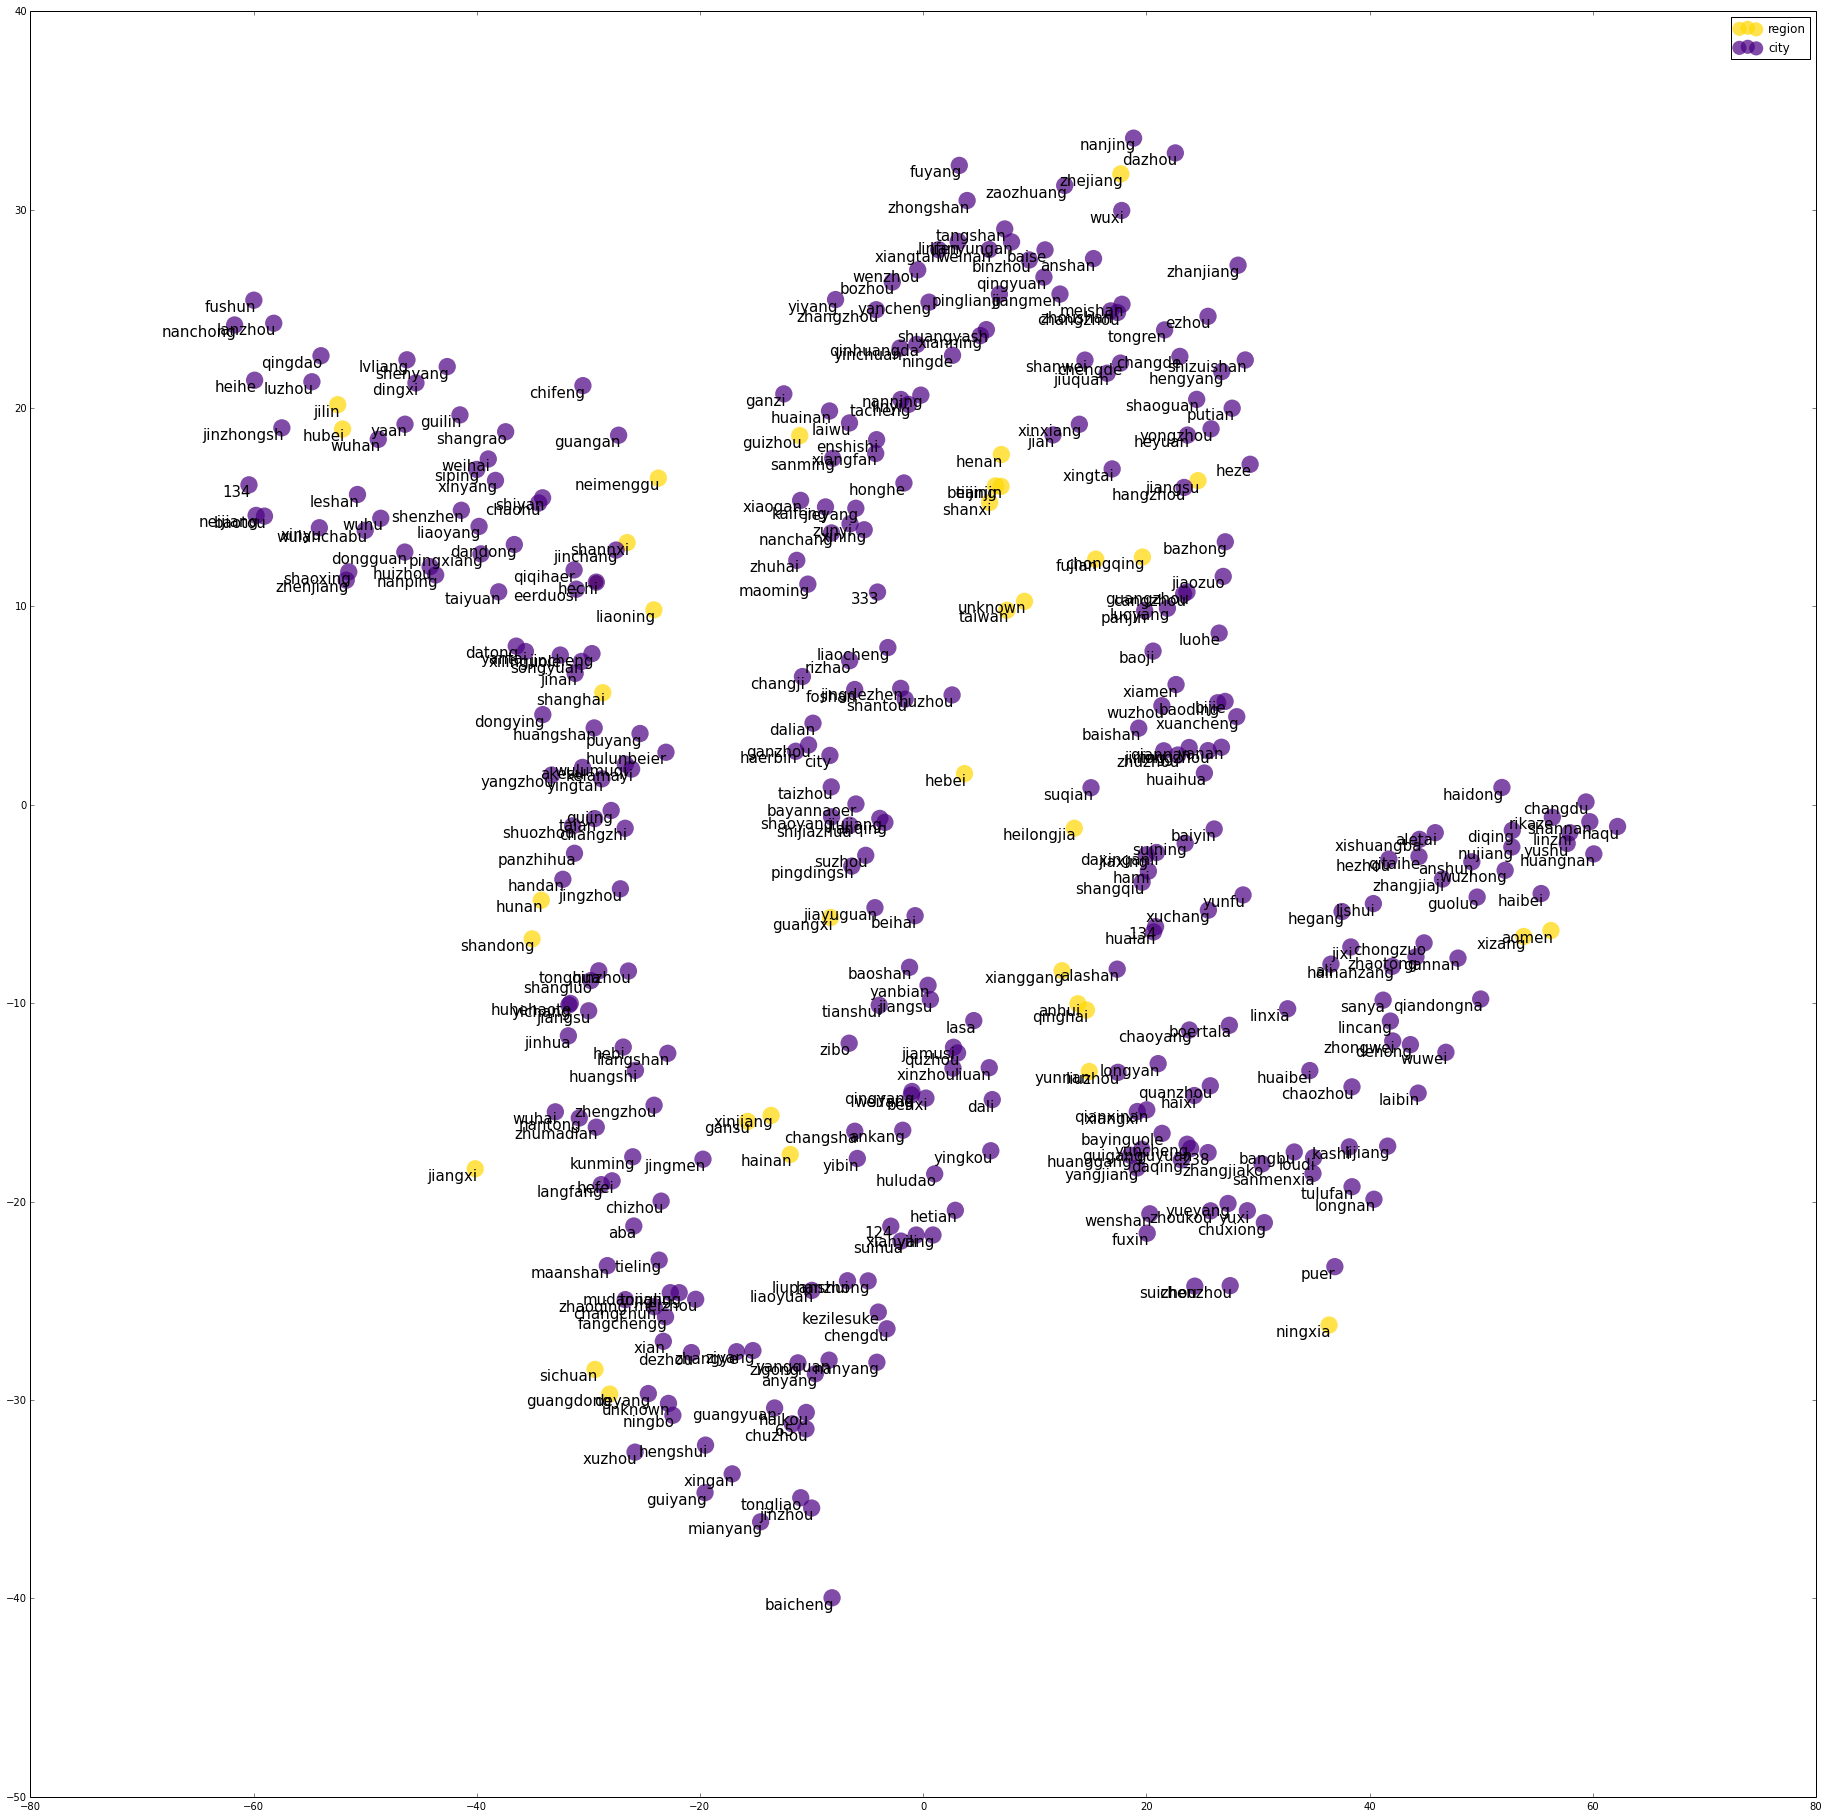

In [50]:
# for city and region
index = []
for key in dictionary.keys():
    if 'city' in key or 'region' in key:
        index.append(dictionary[key])
tsne = TSNE(perplexity=20, n_components=2, init='pca', n_iter=1500)
low_dim_embs = tsne.fit_transform(final_embeddings[index])
labels = [reverse_dictionary[i].split('_')[-1][0:10] for i in index]
cates = [reverse_dictionary[i].split('_')[0] for i in index]
# cates = ['_'.join(cat) for cat in cates]
plot_with_labels(low_dim_embs, labels, cates ,filename='city_region_dirc_32_random_3.pdf')
# plot_with_labels(low_dim_embs, labels, c, )

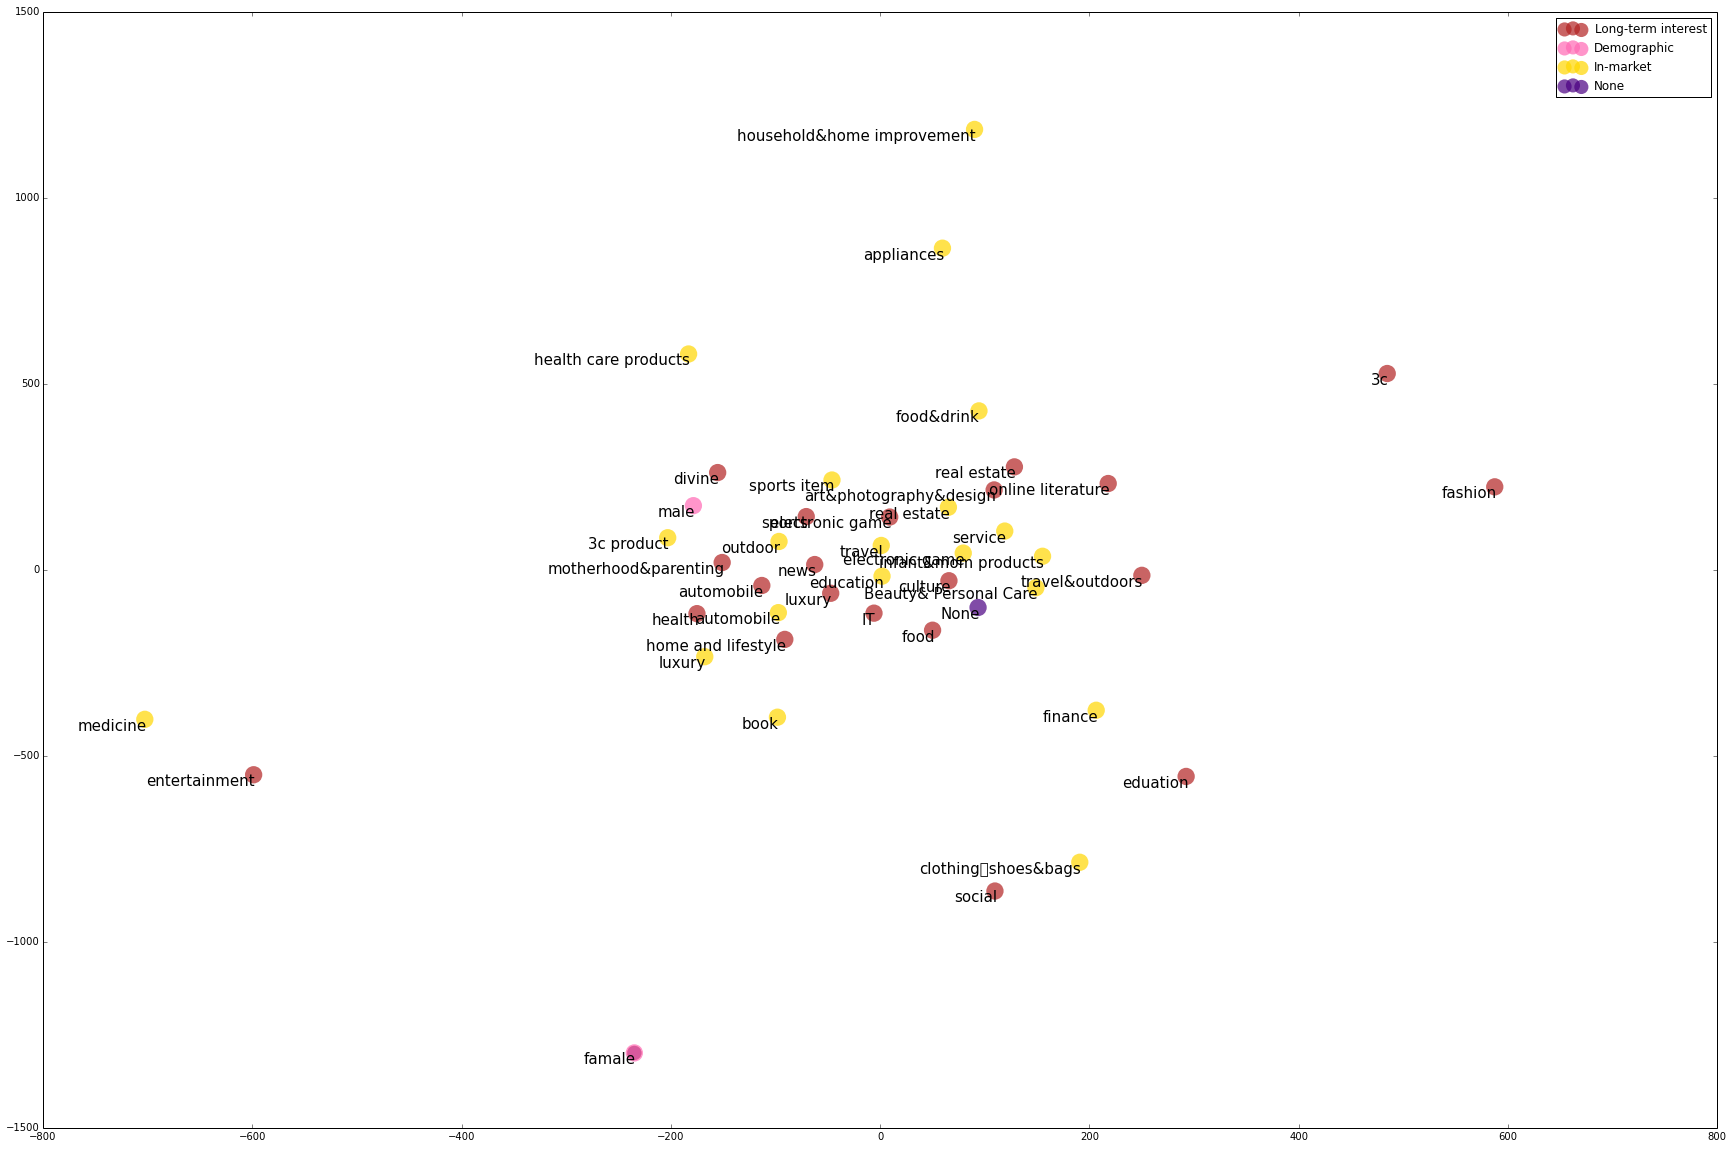

In [62]:
# # for tag
index = []

for key in dictionary.keys():
    if 'user_tags' in key:
        index.append(dictionary[key])
if len(index) > 500:
    index = index[0:500]
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=1000)
low_dim_embs = tsne.fit_transform(final_embeddings[index])
labels = [str(reverse_dictionary.get(i)).decode('utf-8').split('_')[-1] for i in index]
cates = [l.split('/')[0] for l in labels]
labels = [l.split('/')[-1] for l in labels]
plot_with_labels(low_dim_embs, labels, cates ,filename='tags_discr_32.pdf')
# plot_with_labels(low_dim_embs, labels)